# Automating the boring things

In the previous chapters we initialized our image calculator library, did some planning (both short and long term), and started implementing some new features with some unit tests to make sure it is working as expected. We finished the previous chapter by submitting a Pull Request that ended up merging into our development branch `dev`.

Even if we didn't ask for any review (as we are working alone in this tutorial), it could be interesting to swap our position with the one of the reviewer. Imagine you just got tagged to review our previous PR. When you receive the notification, chances are that you have absolutely no clue what the hell is going on in the code. Even the big picture might be missing in your brain.

Because our PR is incremental and linked to a detailed issue, you, as a reviewer, can start by refreshing your mind by reading the issue (and potentially related issues...). Once the big picture of why we are doing that and how we agreed on doing it, then you can come back to the PR.

Before diving into the code diff, you might wonder whether the code is:

- well formatted (meaning that it follows conventions from the team, which can be inspired by usual rules like PEP8)
- not breaking anything
- well tested and functional

## Automatically formatting the code and checking the syntax

The formatting part is one of the most boring thing to do as a reviewer ! Imagine yourself tracking all lines exceding some length, spotting forgotten white spaces between operators, or chasing trailing whitespaces... Your time is clearly more important than that ! Moreover, your review could take ages and discourage the contributor with thousands of meaningless stuffs to change.

Luckily, there are tools that can take care of that for us ! The idea is simple: we configure the tool to give it our conventions (for example with don't want lines longer than 88 characters), we use it to automatically format our local files before committing them, and we commit our tool configuration to version control such that other contributors can use it as well. If all contributors are using the same tool with the same configuration, then the code base will be totally consistent and discussions about formatting won't even exist in PRs.

These tools are called code formatters and there exists multiple solutions for Python. A direct extension to formatters are called *code linters* and are focused on analyzing the code for potential errors, bugs, stylistic errors, or weird constructs. They detect a whole range of bugs like syntax errors and are extremely useful when used with formatters.

### Ruff, the blazingly fast linter and formatter

In the Aramis team, we are mostly using [Ruff](https://docs.astral.sh/ruff/), which is a super fast code formatter and linter for Python. It is written in Rust and is orders of magnitude faster than older tools such as Black for example.

Let's install Ruff as always, with Poetry:

```bash
$ poetry add ruff --group dev
Using version ^0.12.0 for ruff

Updating dependencies
Resolving dependencies... (0.8s)

Package operations: 1 install, 0 updates, 0 removals

  - Installing ruff (0.12.0): Downloading... 87%
  - Installing ruff (0.12.0)

Writing lock file
```

You can check that Ruff was added to the dev dependencies in the `pyproject.toml` file:

```toml
[tool.poetry.group.dev.dependencies]
pytest = "^8.4.1"
pytest-cov = "^6.2.1"
ruff = "^0.12.0"
```

As mentioned above, we need to give our conventions to Ruff such that it can perform its work. Of course, Ruff comes with good defaults such that we don't have much to configure. You can add the following at the end of your `pyproject.toml` file:

```toml
[tool.ruff]
line-length = 88

[tool.ruff.lint]
select = ["E", "F", "W", "I"]
ignore = ["E501"]

[tool.ruff.lint.isort]
known-first-party = ["calculator"]

[tool.ruff.format]
quote-style = "double"
indent-style = "space"
```

Feel free to take a closer look at the documentation of Ruff to better understand these rules and see the extent of what is possible with Ruff.

Now that we have Ruff installed and configured, we can check our code base:

```bash
$ poetry run ruff check .
tests/unittests/image_test.py:1:1: I001 [*] Import block is un-sorted or un-formatted
  |
1 | / import numpy as np
2 | | from calculator.image import Image
  | |__________________________________^ I001
  |
  = help: Organize imports

Found 1 error.
[*] 1 fixable with the `--fix` option.
```

Ruff found on error in one of our tests. It looks like it is unhappy with the imports inside one of our test function but it also tells us it is able to automatically fix the problem for us, we only need to pass the `--fix` option:

```bash
$ poetry run ruff check --fix .
Found 1 error (1 fixed, 0 remaining).
```

We can look at the diff of our test file to see that Ruff automatically added a line in between the numpy import and the internal import of `Image`. It is indeed a recommendation to structure your imports in such a way. We can already see how Ruff is going to save a lot of our time by fixing boring things like this.

```bash
$ git diff tests/unittests/image_test.py
diff --git a/tests/unittests/image_test.py b/tests/unittests/image_test.py
index a38faaa..2357ed4 100644
--- a/tests/unittests/image_test.py
+++ b/tests/unittests/image_test.py
@@ -1,4 +1,5 @@
 import numpy as np
+
 from calculator.image import Image
```

Let's commit this and push:

```bash
$ git add poetry.lock pyproject.toml tests/unittests/image_test.py
$ git commit -m "Add and configure Ruff, sanitize code base"
$ git push origin dev
```

### Going further: the pre-commit hooks

Being able to do that is already great but we can go further than that. Ideally, once the code base is sanitized, we can only introduce violations to our rules with commits. So, we don't really have to run Ruff all the time on the full code base, we only need to run it at each commit on the diff of the commit. If what we modified is fixable by Ruff, we want it to fix it and let us know it did something. If there is something that Ruff cannot fix, then we want it to give us a meaningful error and stop us from committing bad code.

Having something running everytime we make a commit is not a novel idea and is exactly what [pre-commit](https://pre-commit.com) does!

Let's install `pre-commit` with Poetry:

```bash
$ poetry add pre-commit --group dev
Using version ^4.2.0 for pre-commit

Updating dependencies
Resolving dependencies... (11.3s)

Package operations: 9 installs, 0 updates, 0 removals

  - Installing distlib (0.3.9)
  - Installing filelock (3.18.0)
  - Installing platformdirs (4.3.8)
  - Installing cfgv (3.4.0)
  - Installing identify (2.6.12)
  - Installing nodeenv (1.9.1)
  - Installing pyyaml (6.0.2)
  - Installing virtualenv (20.31.2)
  - Installing pre-commit (4.2.0)

Writing lock file
```

Now that we have `pre-commit` installed, we need to configure it to use Ruff. The configuration of pre-commit hooks is done through a file named `.pre-commit-config.yaml` (mind the leading dot!) at the root of the project. Let's add the following content to it:

```yaml
repos:
  - repo: https://github.com/astral-sh/ruff-pre-commit
    rev: v0.2.2
    hooks:
      - id: ruff
        args: [ --fix ]
      - id: ruff-format
```

Let's commit our changes before testing the pre-commit hook:

```bash
$ git add poetry.lock pyproject.toml .pre-commit-config.yaml
$ git commit -m "Configure pre-commit hook using Ruff"
$ git push origin dev
```

Let's test our pre-commit hook by implementing one of the custom constructor for our `Image` class and volontarily introduce weird syntax. Since we are going to work on a new feature, let's create a dedicated branch:

```bash
$ git switch -c implement-custom-constructors-for-image
Switched to a new branch 'implement-custom-constructors-for-image'
```

We can install the hooks that we configured:

```bash
$ poetry run pre-commit install
pre-commit installed at .git/hooks/pre-commit
```

You can now open the file `src/calculator/image.py` and add the following:

```python
(...)
class Image:
    (...)

    @classmethod
    def from_array(cls,  data:list):

        return cls(np.array(data))
```

We can add and commit those changes as always:

```bash
$ git add src/calculator/image.py
$ git commit -m "Add from_array constructor to Image class"
[WARNING] Unstaged files detected.
[INFO] Stashing unstaged files to /Users/nicolas.gensollen/.cache/pre-commit/patch1750345733-18444.
[INFO] Installing environment for https://github.com/astral-sh/ruff-pre-commit.
[INFO] Once installed this environment will be reused.
[INFO] This may take a few minutes...
ruff.....................................................................Passed
ruff-format..............................................................Failed
- hook id: ruff-format
- files were modified by this hook

1 file reformatted

[INFO] Restored changes from /Users/nicolas.gensollen/.cache/pre-commit/patch1750345733-18444.
```

A few things are happening here. First, the needed tools are installed in a virtual environment. This takes some time but will only happen once. The next time we make a commit, the virtual environment that we just created will be used. Then we can see that the `ruff-format` hook failed and we see that 1 file was modified by our pre-commit hook.

Since we are using git, we can easily see what file was modified and what was changed:

```bash
$ git diff src/calculator/image.py
-    def from_array(cls,  data:list  ):
-
-
+    def from_array(cls, data: list):
```

We can see that our pre-commit hook did a good job at reformatting our junk code: white spaces were removed or added and the extra line was removed.

Something important to understand is that our attempt at doing a commit was canceled and that, while the pre-commit hook modified some files for us, it did take the liberty of committing its modifications itself. We need to inspect them and if we agree with them, add them, and re-commit:

```bash
$ git add src/calculator/image.py
$ git commit -m "Add from_array constructor to Image class"
ruff.....................................................................Passed
ruff-format..............................................................Passed
[implement-custom-constructors-for-image e615a2a] Add from_array constructor to Image class
 1 file changed, 3 insertions(+), 1 deletion(-)
```

This time all pre-commit hooks were successful and we managed to make our commit, with well formatted code even though this is clearly not what we wrote.

At this point, your project should look like this:

```bash
.
├── .gitignore
├── .pre-commit-config.yaml
├── LICENSE
├── README.md
├── environment.yml
├── poetry.lock
├── pyproject.toml
├── src
│   └── calculator
│       ├── __init__.py
│       └── image.py
└── tests
    └── unittests
        └── image_test.py
```

Let's take a break from our feature implementation and switch back to the `dev` branch:

```bash
$ git switch dev
```

### Going even further: the github action

In this section, we are going even further than what we just did. The issue with our pre-commit hooks is that their installation isn't mandatory. This means that contributors can still decide to not install them in their local environments. They will thus produce commits with code that don't follow our policy which will still be a pain to review.

We *could* just tell them to install the pre-commit hook, and re-commit their work, but it's time consumming and we need to be able to spot these small issues to understand that the hook wasn't installed in the first place. That's way too much work and hopefully, there is a solution to this.

Until now, we made the pre-commit hook run on our local machine. What we want to do now is to run the hook on the Github infrastructure such that, no matter what contributors did with their setups, the pre-commit will run in the Pull Request before the code is merged. If the hooks fail, Github will let us and the contributors know about it. This kind of mechanisms is called a *GitHub action* and it is a mechanism at the base of the Continuous Integration.

Let's see waht this is all about !

```
$ mkdir -p .github/workflows
```

Then create a file `.github/workflows/lint.yaml` with the followwing content:

```yaml
name: Lint and format code

on:
  push:
    branches: [ "dev", "main" ]
  pull_request:
    branches: [ "dev", "main" ]

permissions:
  contents: read

jobs:
  lint:
    runs-on: ubuntu-latest
    steps:
      - uses: actions/checkout@v4
      - uses: actions/setup-python@v5
        with:
          python-version: '3.x'
      - uses: pre-commit/action@v3.0.1
```

```bash
$ git add .github/workflows/lint.yaml
$ git commit -m "Add lint workflow to CI"
$ git push origin dev
```

Go to your repository on Github and navigate to the dev branch. You should now see a small gree tick mark next to the last commit. Note that you can also have a red cross, we'll explore later in this tutorial what it means and how to fix it.

If you click on the gree tick mark, you should see a list of workflows with their names, their durations and whether they succeeded or not (green tick vs. red cross):

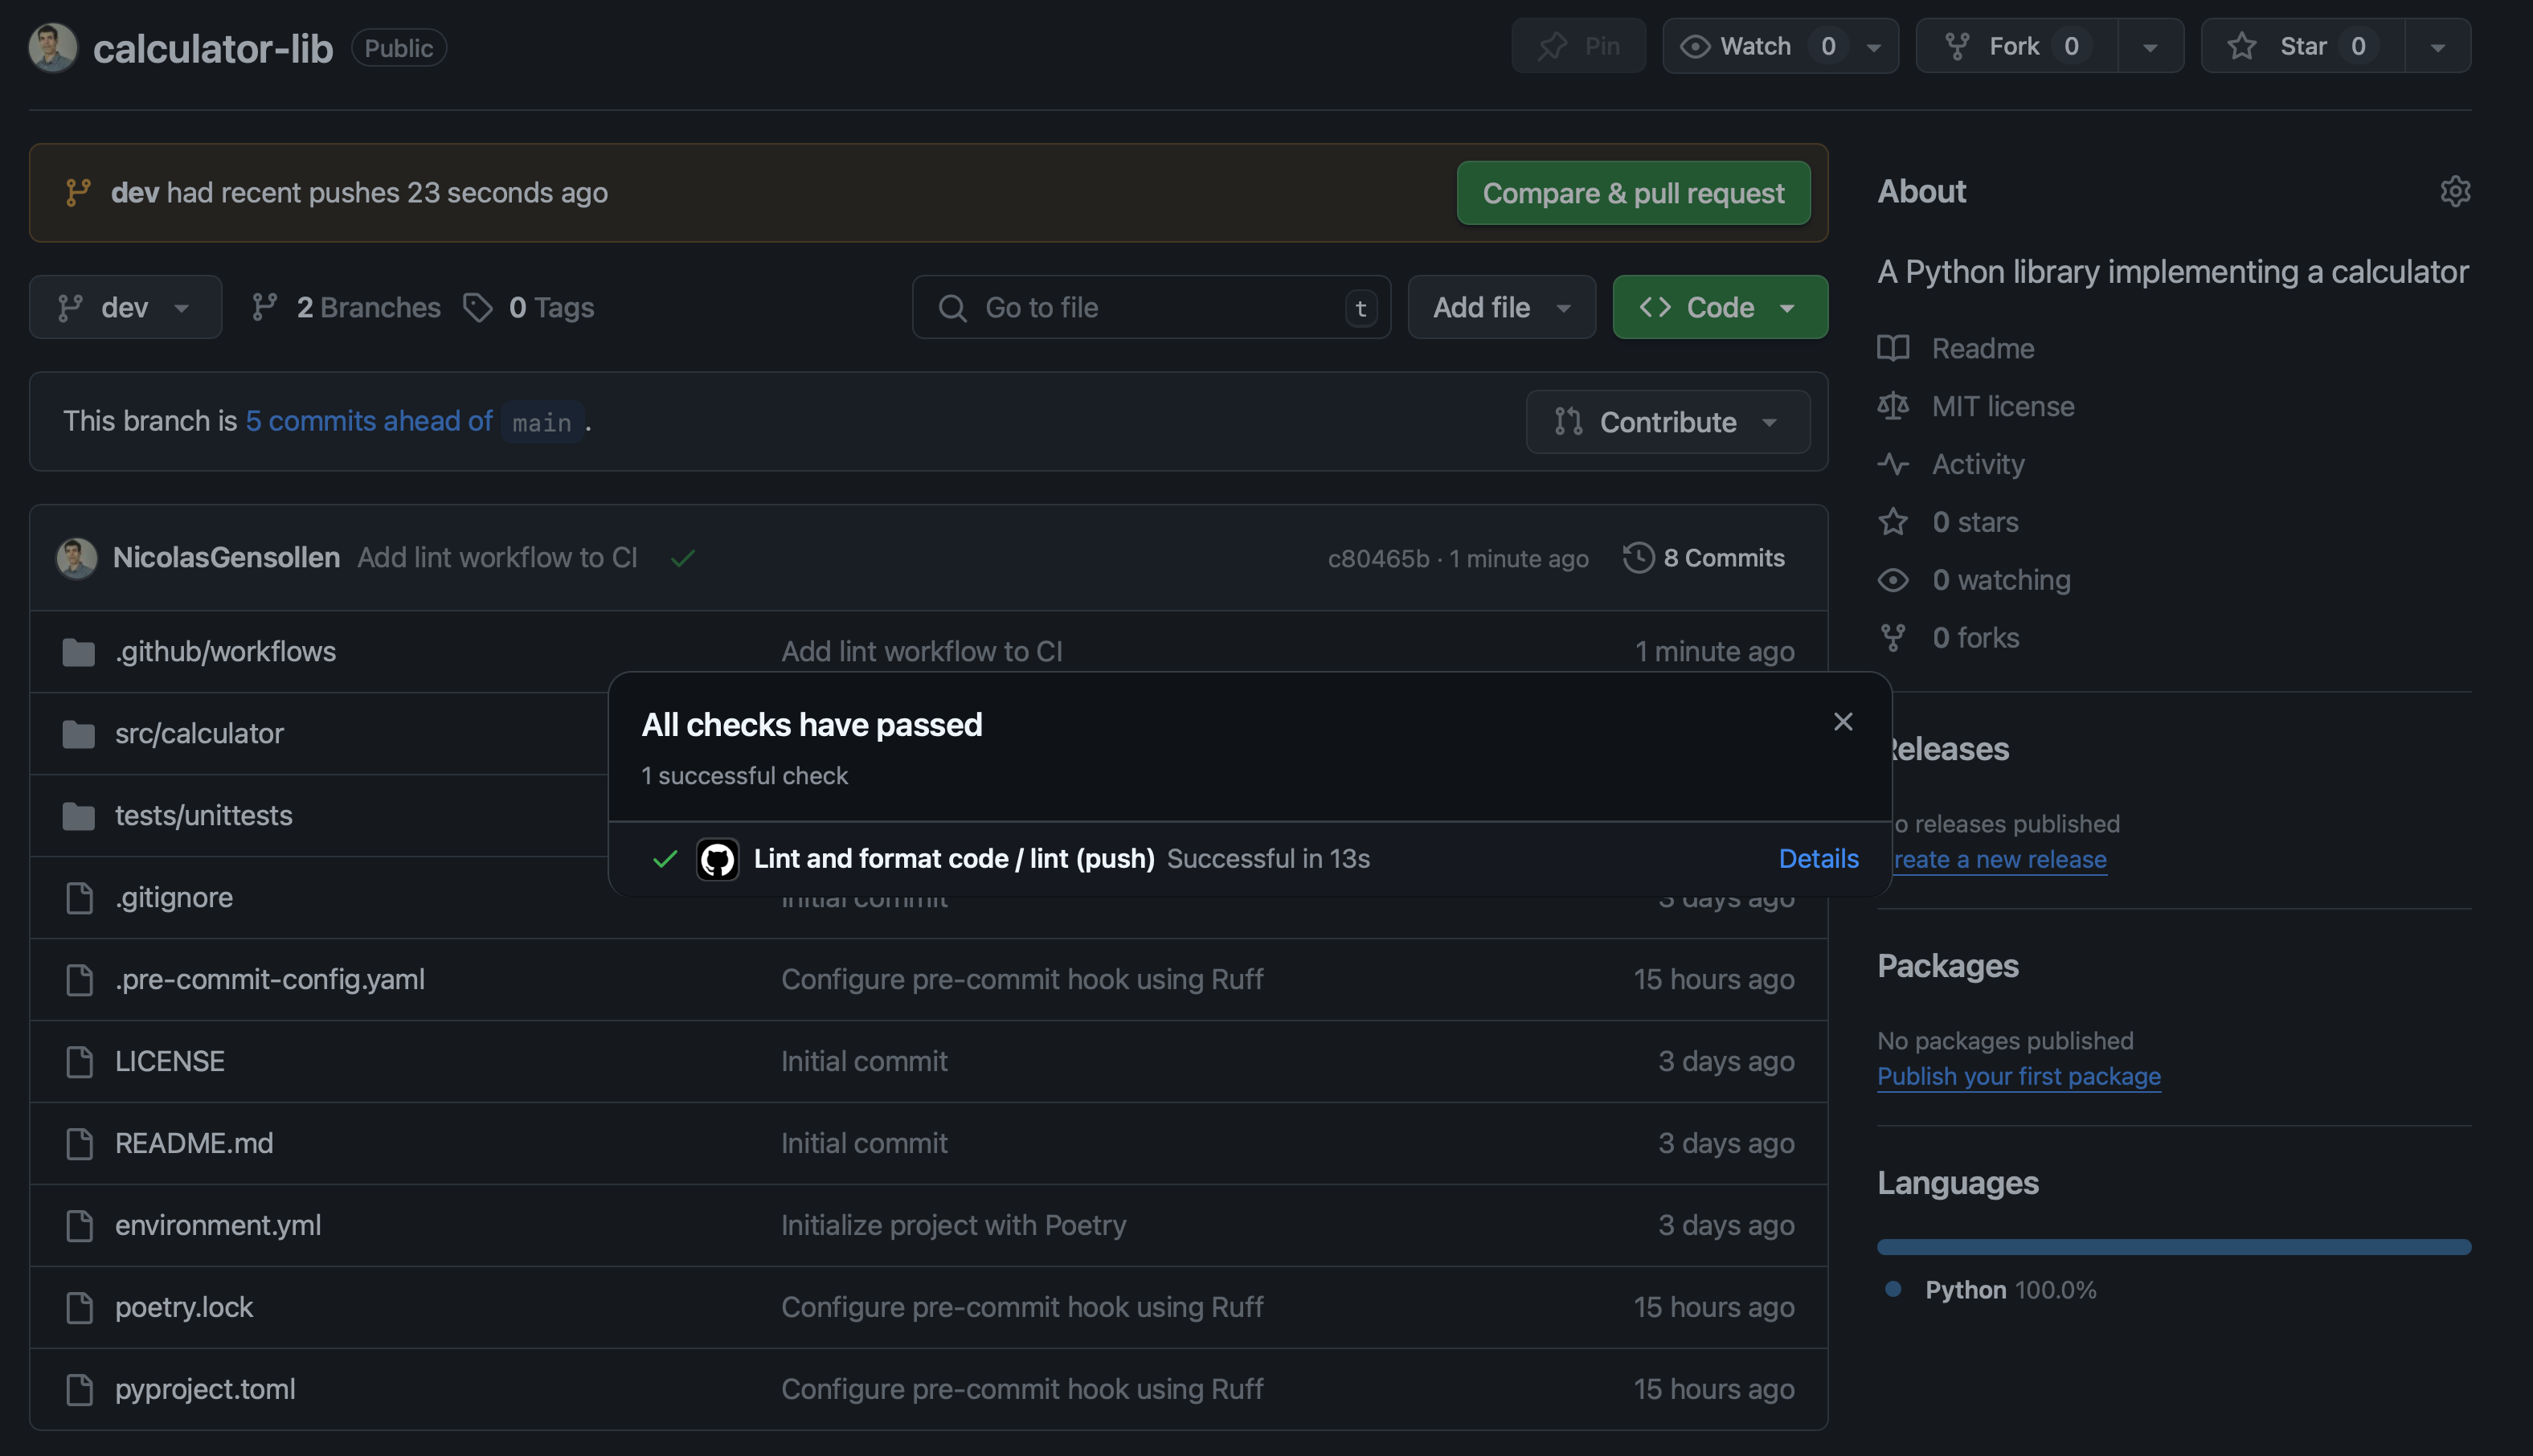

In [1]:
from IPython.display import Image

Image(filename="../images/github_action_lint_1.png")

If you click on "details" next to the workflow you should get to a new page in the "Actions" tab looking like this:

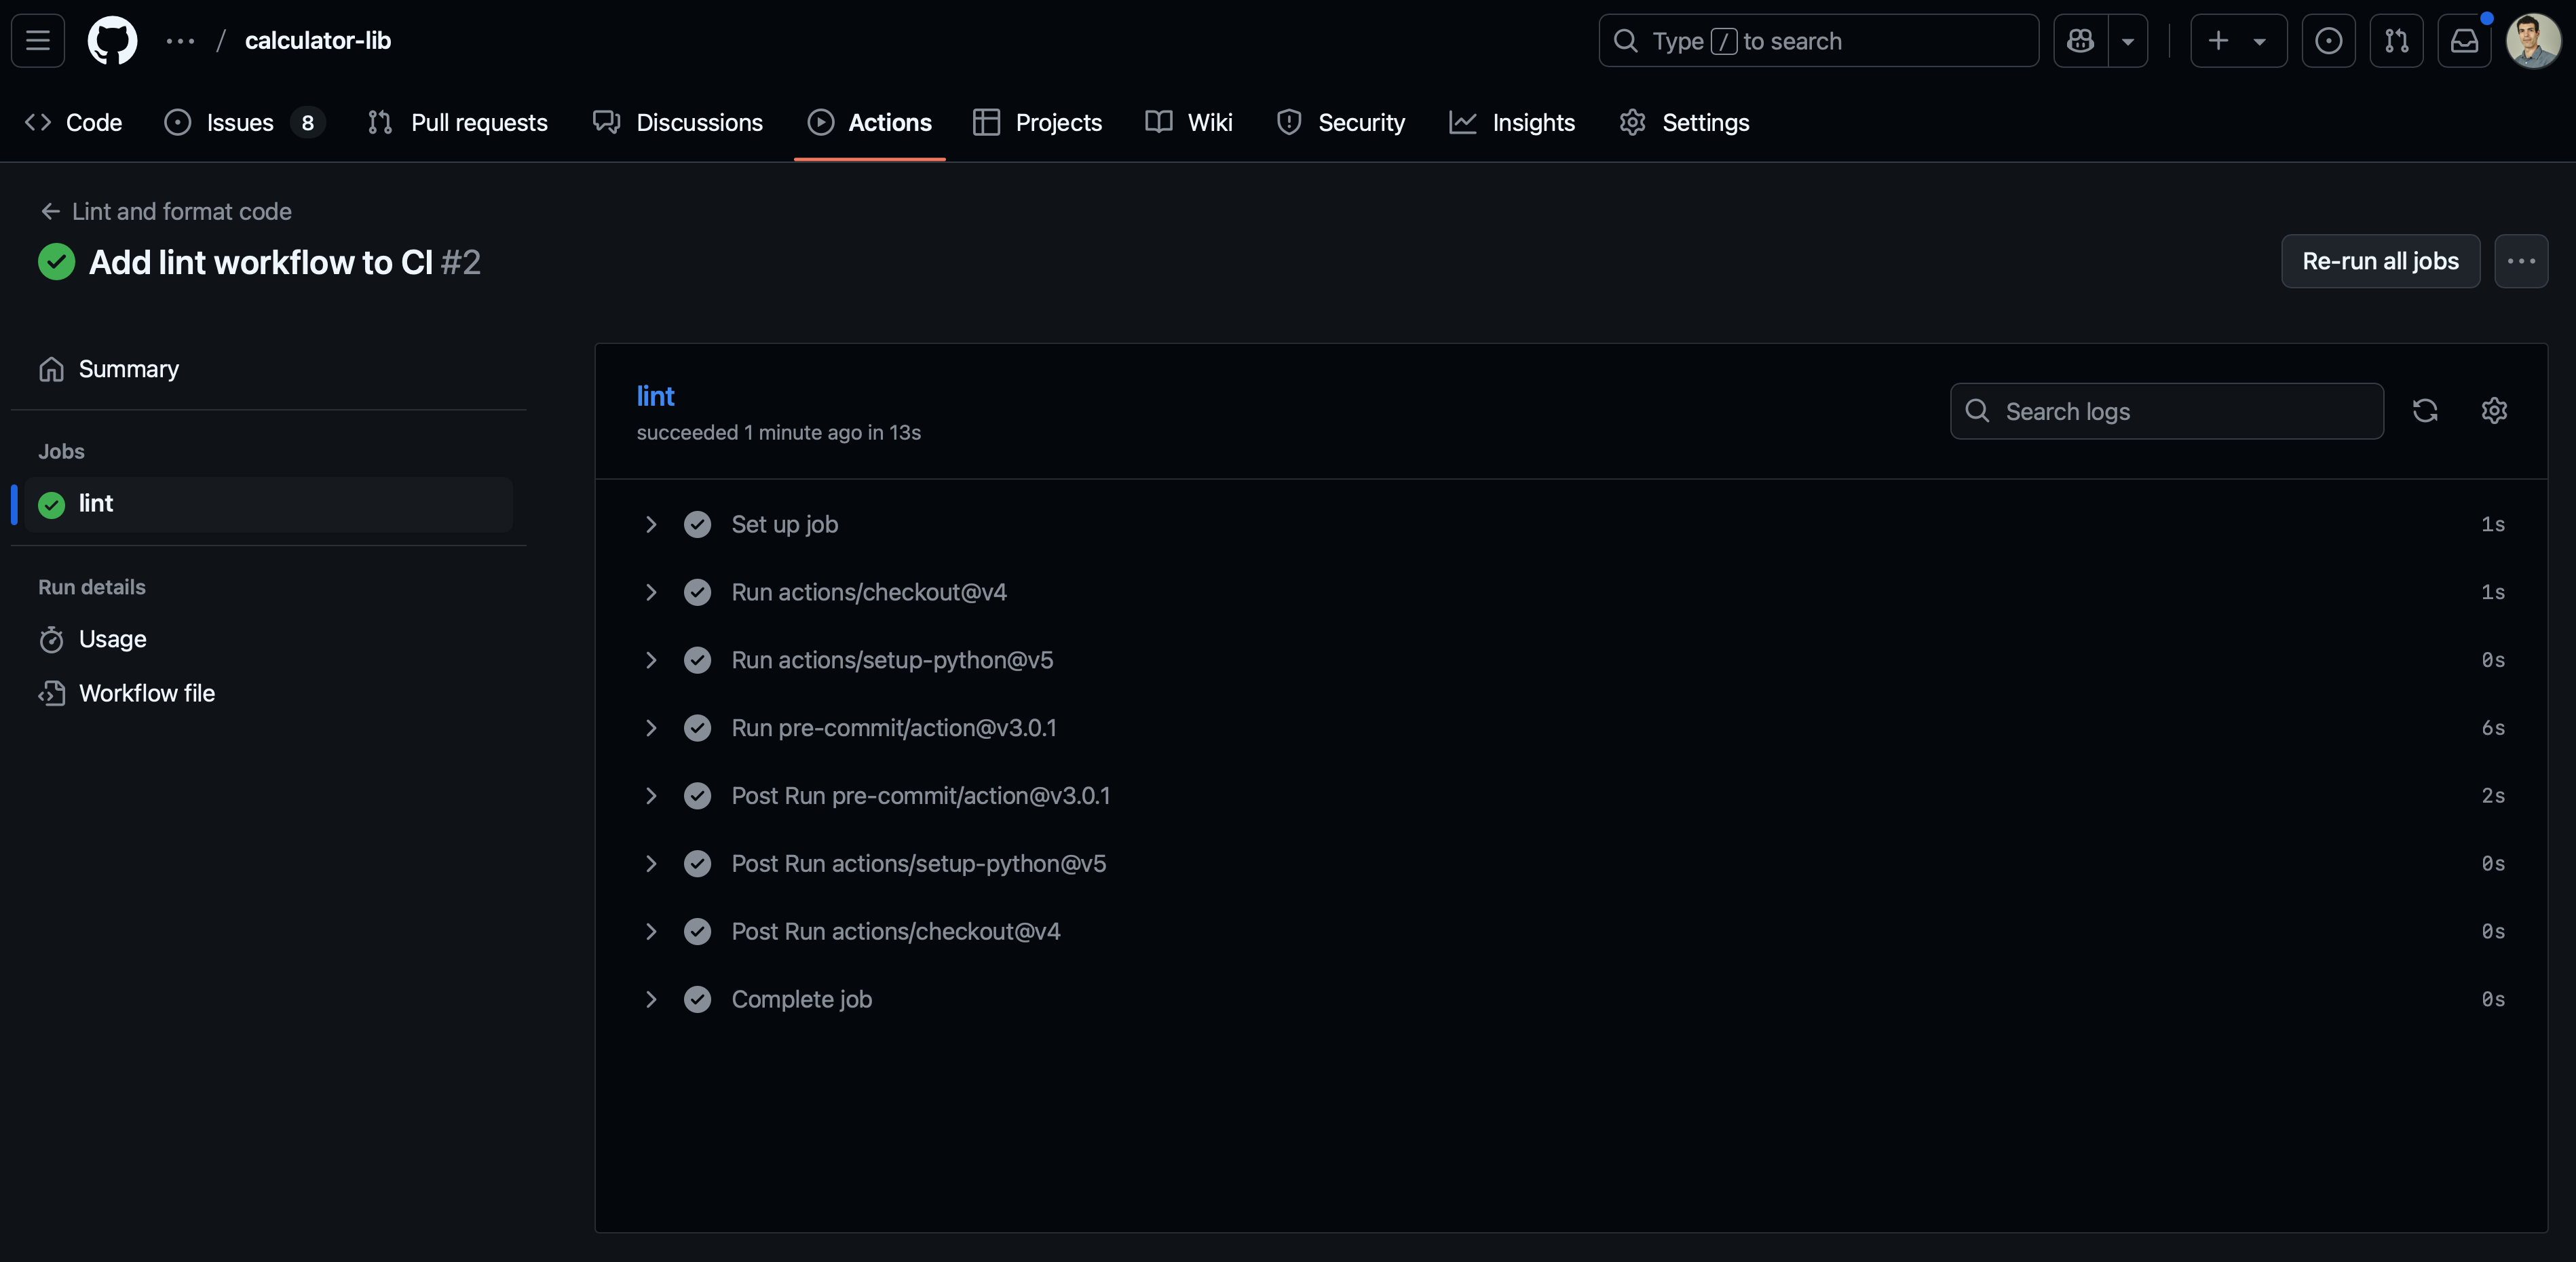

In [2]:
Image(filename="../images/github_action_lint_2.png")

This page gives you the details of what happened in the workflow run. As you can see, there are several steps performed even for a super simple workflow like this one. You can probably see some correspondance between these steps and the yaml file giving the workflow specifications.

The core of the work for this workflow is being done in the step called "Run pre-commit/action@v3.0.1". If you expand this step, you get the output logs of what happened. You should recognize, at the end, the output from Ruff that you got on your own terminal before. Ruff is succeeding and the whole workflow is successful. Great !

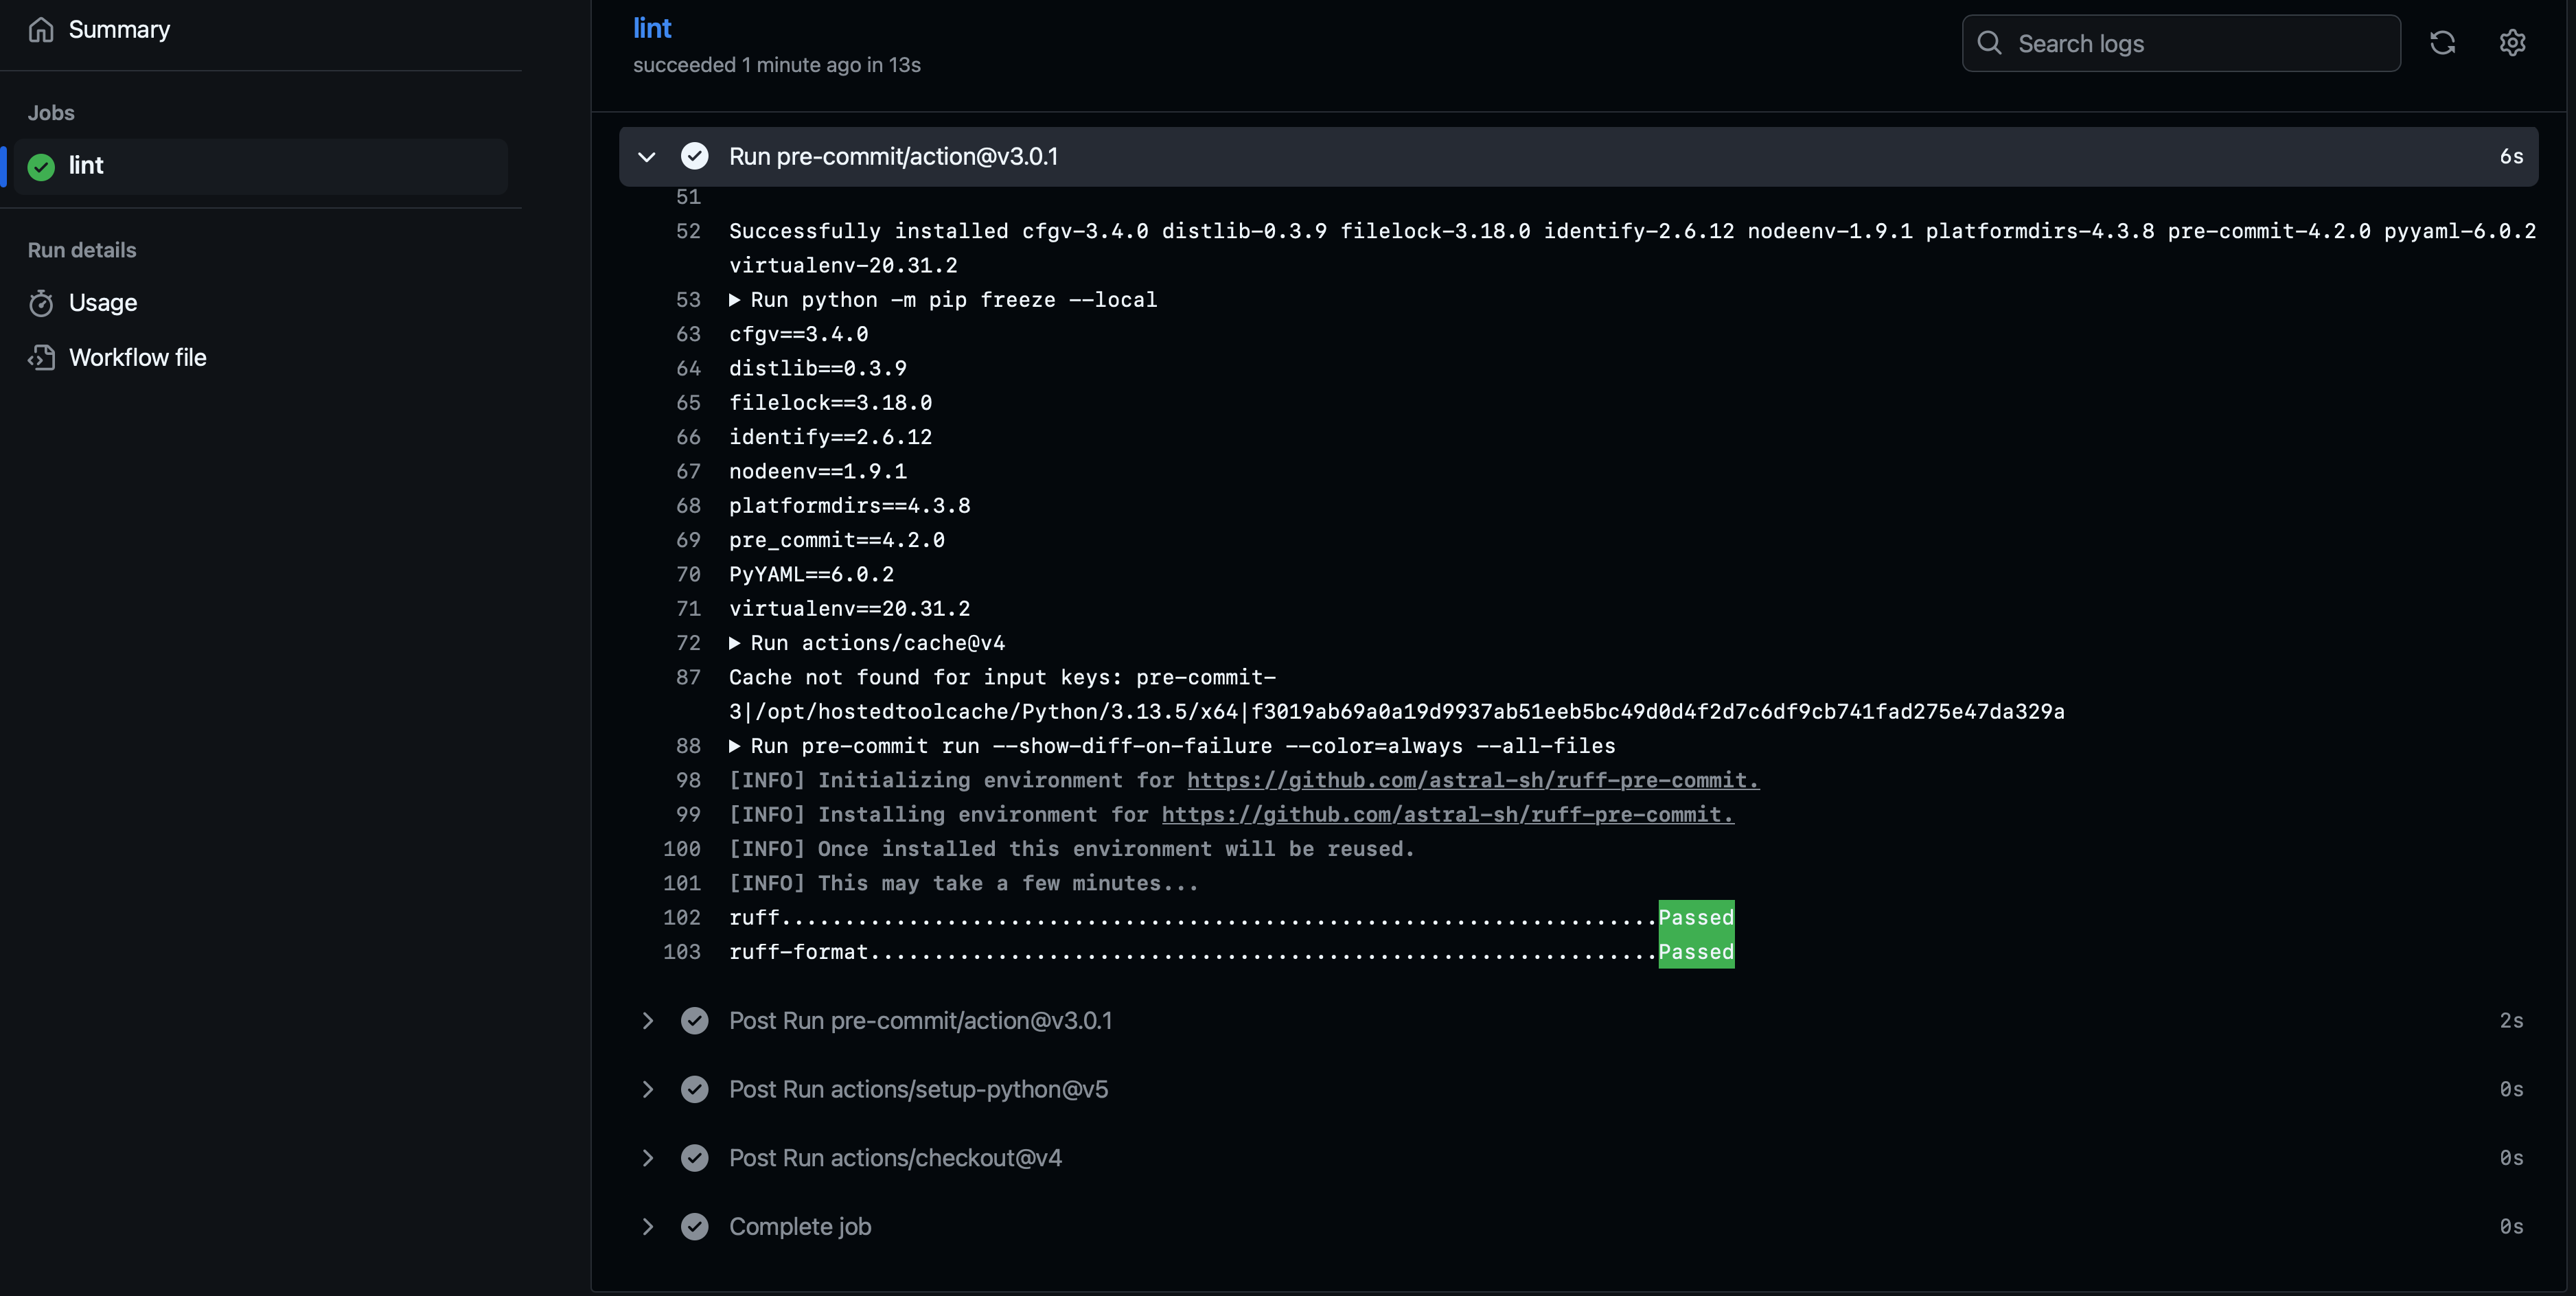

In [3]:
Image(filename="../images/github_action_lint_3.png")

### Catching badly formatted code with the CI

Let's go back to our feature branch and continue working on it:

```bash
$ git switch implement-custom-constructors-for-image
Switched to branch 'implement-custom-constructors-for-image'
```

Open `src/calculator/image.py` and add the following (very bad) Python code with, again, bad formatting:

```python
(...)
class Image:
    (...)
    @classmethod
    def from_file( cls,  file_path:str)  :
        with open(file_path , 'r')    as fp:
            content= fp.readlines( )
        import json
        return cls.from_array(json.loads(
            content[0]))
```

We are not super sure that our implementation is bullet proof, but it looks like it could more or less do the job. To get more confidence, let's write some unit tests !

#### Using the tmp_path pytest fixture to isolate unit test data

Testing this method is a bit more advanced than what we did earlier. First, it expects a file path as input and this file should exist and have some data in it. Should we create a small test file in our tests folder and commit it with the rest of the code? That could be an approach, but that would be terribly wrong in the long run as our repository will get cluttered with small test files with horrible names. Hopefully, there is a much better solution: temporary files and directory.

Remember one of the key principles of unit tests: tests should be independant and self-contained. If our unit tests are touching files from the repository, it won't take long for them to introduce hidden coupling which can lead to terrible bugs. The solution is simple: one unit test = one tmp folder that will exists only while this unit test is running. When it finished, the whole tmp folder is destroyed.

Now, we could implement this ourselves of course, but this is a so common use case, that pytest has already everything we need and it turns out it's dead simple to use! What we want is called the `tmp_path` fixture. Let's see it in action!

Open `tests/unittests/image_test.py` and add the following test (note that again, we're bad at properly formatting our code...):

```python
(...)
def test_image_from_file_constructor( tmp_path) :
    from numpy.testing import assert_array_equal
    (tmp_path / "test_image.img").write_text("[[1,2],[3,4]]")

    img = Image.from_file(str(tmp_path / "test_image.img"))

    assert_array_equal(img._data, np.array([[1, 2],  [ 3,  4]  ])  )
```

Before diving into the code, let's try to run our test:

```bash
$ pytest -vv
===================================================== test session starts ==================================================
platform darwin -- Python 3.12.11, pytest-8.4.1, pluggy-1.6.0 -- /Users/nicolas.gensollen/miniforge3/envs/calculator/bin/python
cachedir: .pytest_cache
rootdir: /Users/nicolas.gensollen/GitRepos/calculator-lib
configfile: pyproject.toml
plugins: cov-6.2.1
collected 4 items

tests/unittests/image_test.py::test_image_instantiation PASSED                                   [ 25%]
tests/unittests/image_test.py::test_image_data_set_correctly PASSED                              [ 50%]
tests/unittests/image_test.py::test_bad_type_in_image_instantiation PASSED                       [ 75%]
tests/unittests/image_test.py::test_image_from_file_constructor PASSED                           [100%]

================================================= 4 passed in 0.12s =========================================================
```

Alright, things are looking good in terms of test execution and our 4 unit tests are passing! Let's get into the code of our last unit test:

- The test is, as usual, a function. But it takes an argument called `tmp_path`. If you look around, you won't see any reference to this, it is an internal "fixture" of Pytest that you can use. If you add it to the arguments of your test, then a tmp folder specific to this test will be available.
- In the second line of our test, we make use of it. Note that `tmp_path` is a `Path` object from the extremely usefull `pathlib` library. A `Path` object is a MUCH better alternative than plain strings to represent paths in file systems.

Always use `Path` objects to represent paths in a file system instead of plain strings.

On this line, you can see some of the benefits of relying on pathlib:

- You can use the "/" operator instead of `os.path.join()`, or even worse, hardcoded "/" or "\" depending on the OS...
- You can rely on methods such as `write_text()` which handle for you the file handle mangement

The code is always much cleaner and easier to read with pathlib, so there is no excuse to not use it.

#### A short word on the public API and "user surface"

We can see on the next line that we are calling our constructor and providing the image file path. However, we have to cast it to a string as our method expects as string. Since we just said that pathlib is better, should we change our method signature to be:

```python
from pathlib import Path
(...)
@classmethod
def from_file(cls, file_path: Path):
    ...
```

It could be a good idead if the method was internal because we would make sure it always receives a Path object. Since it is user-facing, it means that the users will provide a value for this input argument. We could force them to instantiate a Path object and provide it to the constructor method but then they would have to do:

```python
>>> from pathlib import Path
>>> my_image = Path("./my_image.img")
>>> from calculator.image import Image
>>> img = Image.from_file(my_image)
```

That's waaaay too much code to type for such a simple thing. Moreover, now we need our end users to know about pathlib in order to user our library. That's really bad !

We are touching an important area in software design. When it comes to the public API, we should enable our users to provide data with native data types as much as possible. We will then make sure the data is correct by loading it in richer internal data types, and we will internally rely on these rich data types to not repeat our validation code all over the place.

Let's rewrite our constructor with that in mind:

```python
from pathlib import Path

class Image:
    (...)
    @classmethod
    def from_file( cls,  file_path:str | Path)  :
        file_path = Path(file_path)
        import json
        return cls.from_array(json.loads(file_path.read_text()))
```

We allow both strings and Path objects as inputs and we immediately sanitize the user data. We are using the convenient fact that `Path()` is idempotent such that calling `Path()` on a Path object will give us the same object. We then used the fact that we have a Path object to simplify the code: we got read of the whole context manager and the method is now way shorter and easier to read!

#### Using unit tests while refactoring

We can use our unit tests suite to make sure we didn't break anything while refactoring. This is one of the key usage of unit tests: you start with a base implementation, far from perfect, but working more or less. You implement unit tests which will help you fixing bugs and being more confident that the base impleemntation works. Then you can improve the code by rewritting it in a better way: a process called *refactoring*. Every modifications can be validated by running the tests such that you are constently sure that your modifications didn't break the initial functionality.

If you now check the coverage, you will see that we are again at 100% even though we didn't write any tests for the `from_array()` constructor. This is because our `from_file()` constructor is using the `from_array()` constructor such that our unit test is actually executing the code from both constructors, hence the 100% coverage. We decide that it is enough for us and we move on to committing our code.

If we commit our code, our pre-commit hook is gonna run and reformat our work as expected. Let's pretend we are an external contributor who didn't install the pre-commit hook. We can simulate that by passing the `--no-verify` option to `git commit`:

```bash
$ git add src/calculator/_image.py tests/unittests/image_test.py
$ git commit -m "Add from_file constructor to Image class" --no-verify
[implement-custom-constructors-for-image bb0865c] Add from_file constructor to Image class
 2 files changed, 17 insertions(+)
$ git push origin implement-custom-constructors-for-image
```

Go to the repository and open a new Pull Request from `implement-custom-constructors-for-image` to `dev`. Normally, you should see something like this at the end of the PR page:

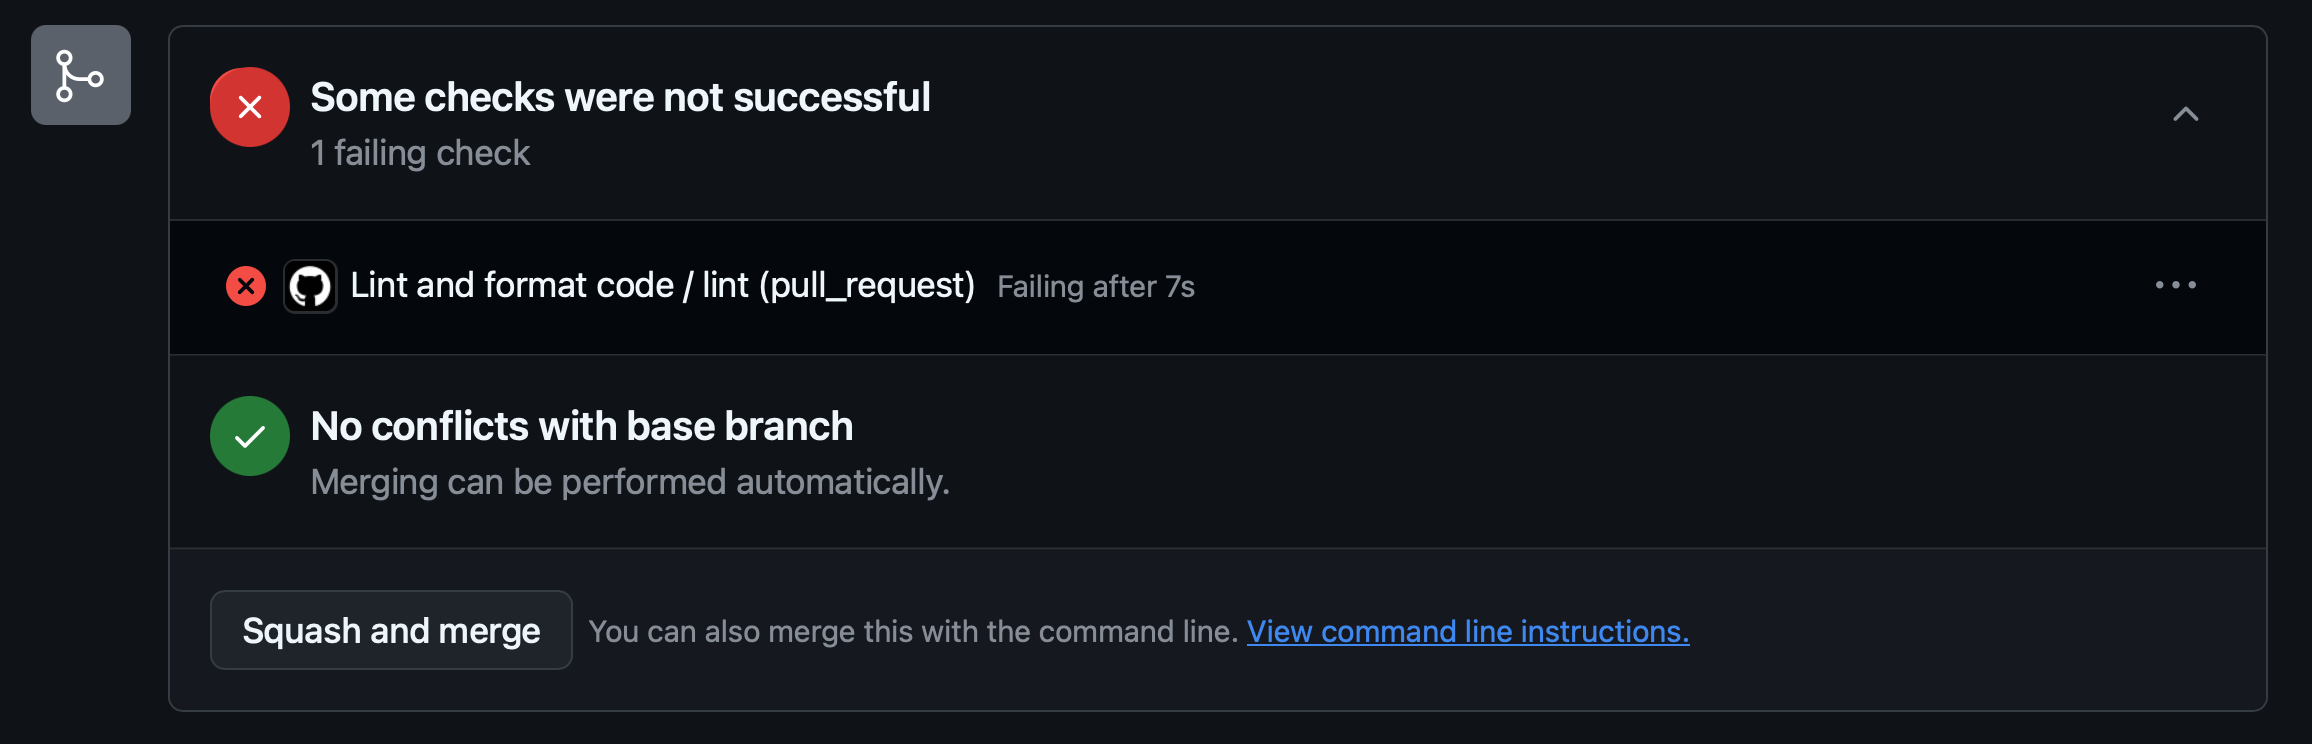

In [6]:
Image(filename="../images/github_action_fail.png")

Github is telling us that the Lint and format code workflow failed. If you go to the details, you should see something like this:

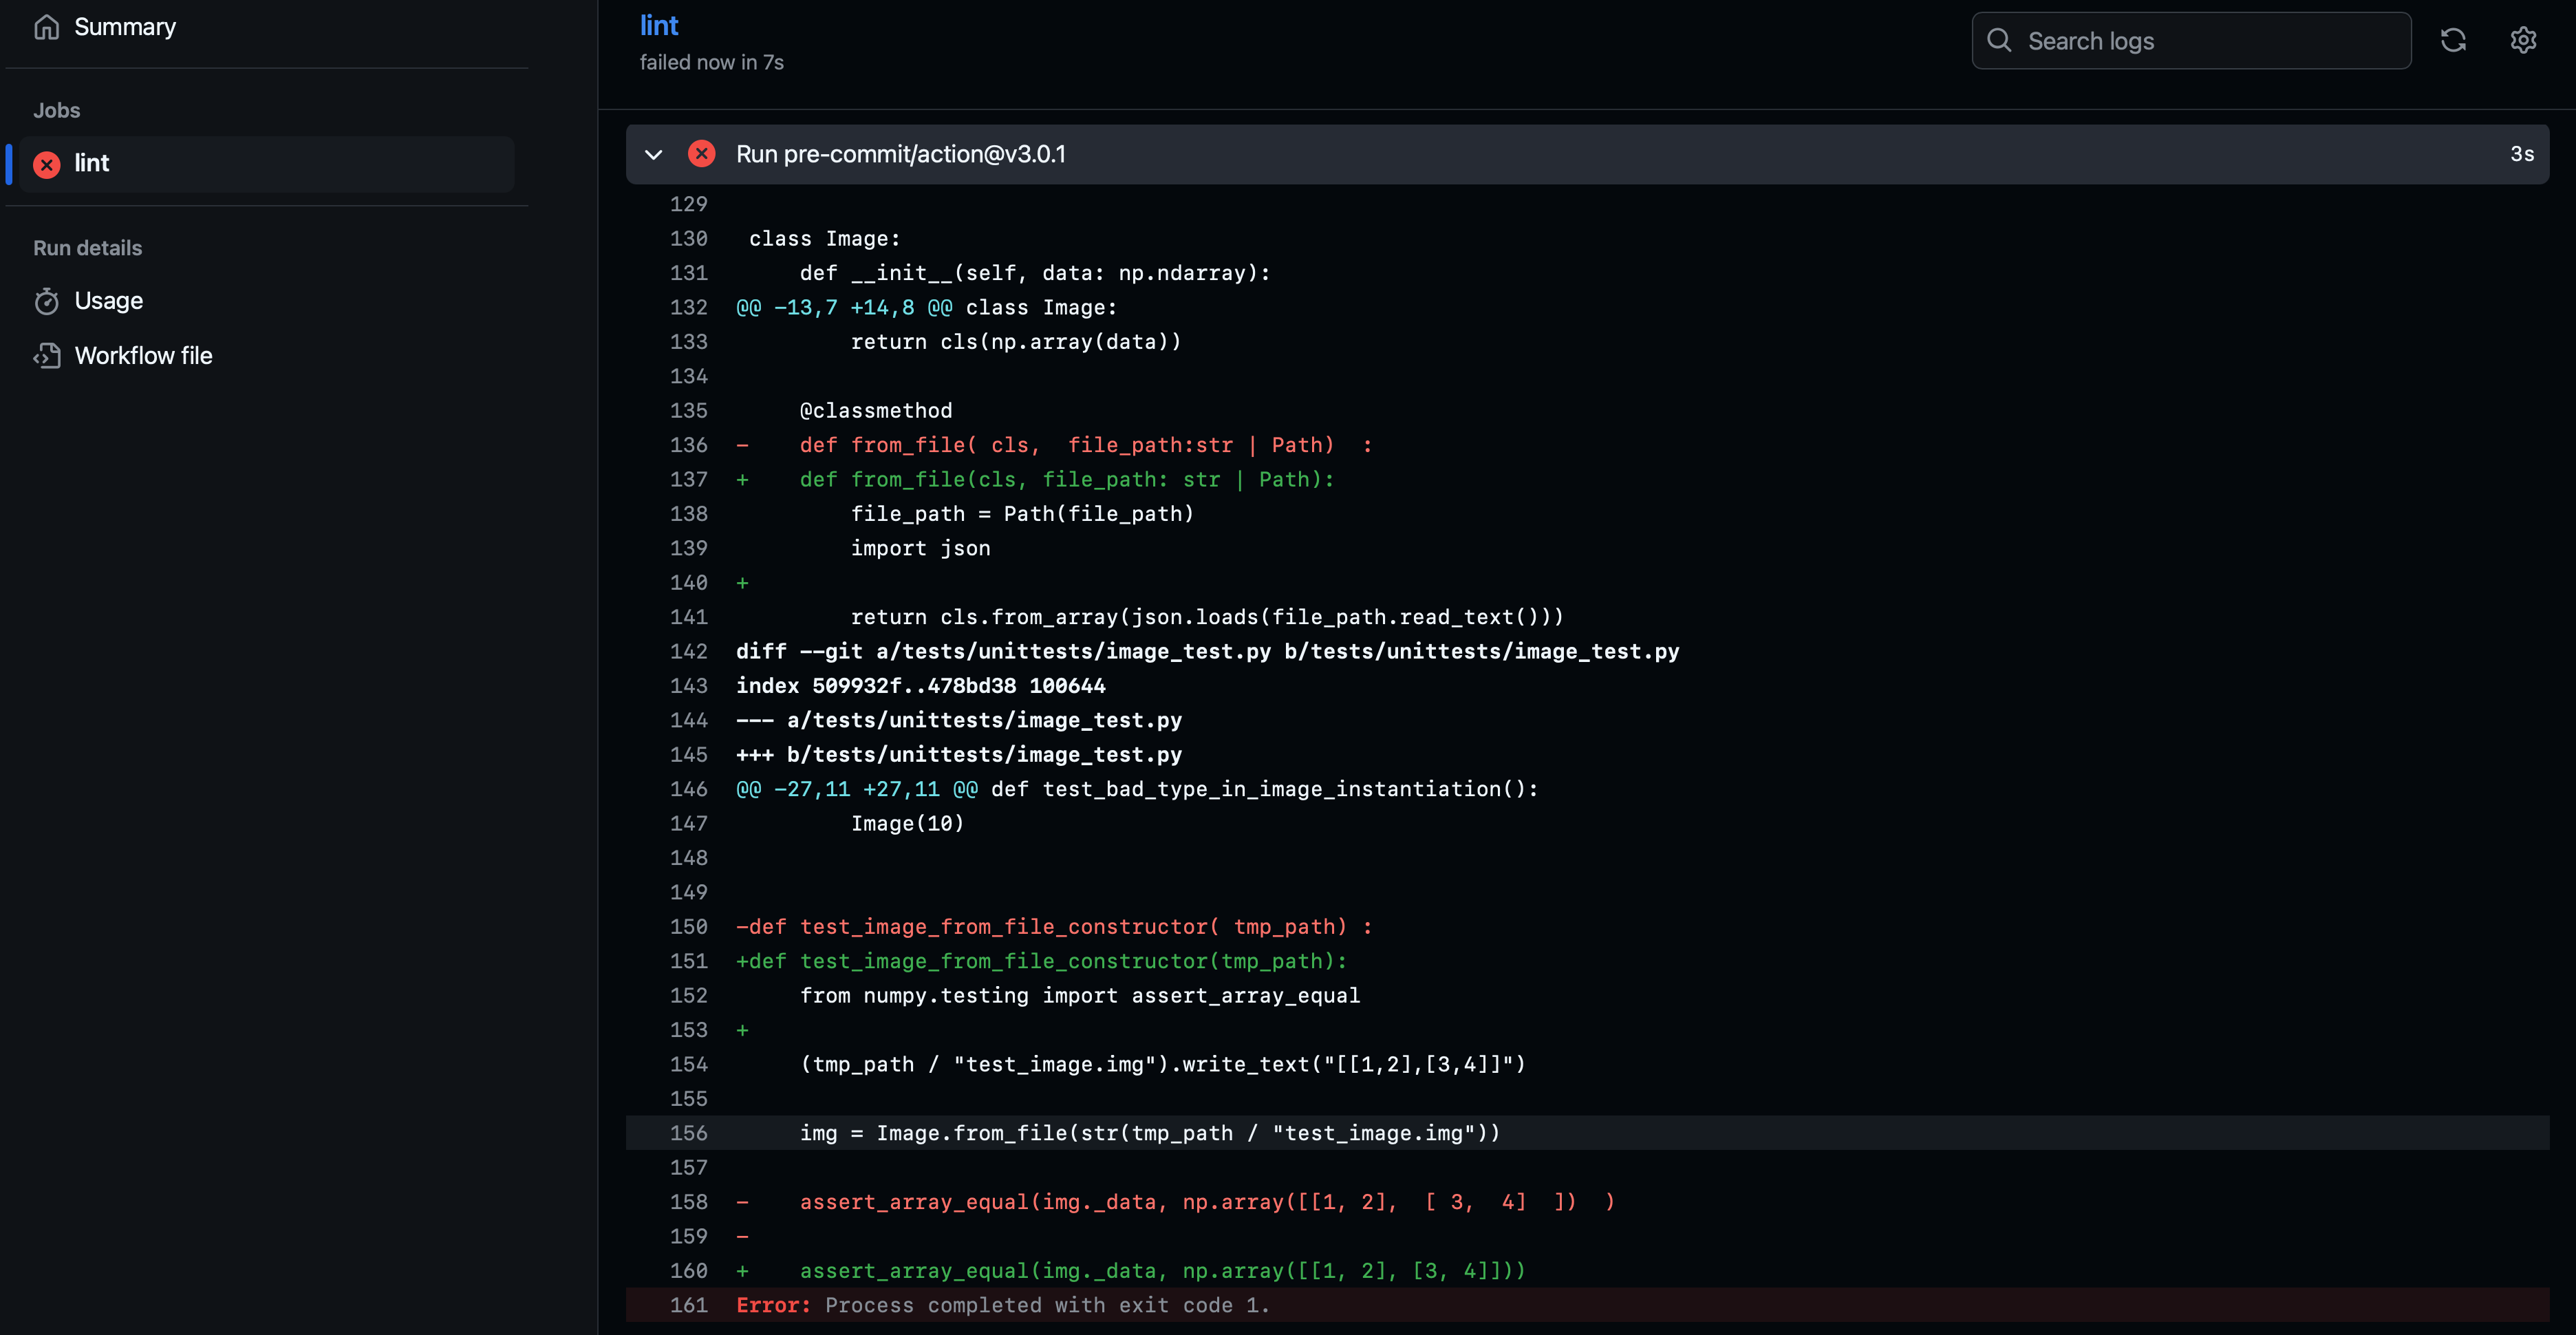

In [5]:
Image(filename="../images/github_action_fail_2.png")

As expected, the CI is failing because our code is badly formatted. The bad code from our fictitious contributor would thus be catched automatically by the CI and we didn't have to do anything ourselves!

With this combination or linter + formatter + pre-commit hooks + github action, we are making sure that our code base will stay formatted in a consistent manner that we defined. We are also removing the burden of reviewing all these small boring details from our shoulders!

Let's fix our mistakes locally by running the pre-commit hook manually on the problematic files:

```bash
$ poetry run pre-commit run --files src/calculator/_image.py tests/unittests/image_test.py
ruff.....................................................................Failed
- hook id: ruff
- files were modified by this hook

Found 1 error (1 fixed, 0 remaining).

ruff-format..............................................................Failed
- hook id: ruff-format
- files were modified by this hook

2 files reformatted
$ git add src/calculator/image.py tests/unittests/image_test.py
$ git commit -m "Lint and format"
ruff.....................................................................Passed
ruff-format..............................................................Passed
[implement-custom-constructors-for-image 082574d] Lint and format
 2 files changed, 7 insertions(+), 5 deletions(-)
$ git push origin implement-custom-constructors-for-image
```

If you go back to the PR, the CI should be all green and we can merge our feature branch into `dev`. As always, clean your local repository:

```bash
$ git switch dev
$ git pull origin dev
$ git branch -D implement-custom-constructors-for-image
```

## Automate the unit tests

The Github actions seem like a super useful tool to automate things. We used it to automatically lint and format our code in order to relieve ourselves from this burden. Remember the begining of this chapter where we thought about our responsibilities as reviewers of a PR.

We still have the responsibility to make sure the code is functional and not breaking anything. It's obvious that a necessary condition for that is that the test suite passes. If all contributors were serious workers, they would have run the test suite before opening the PR. But, unfortunately, this is not always the case and you, as a reviewer, must make sure the tests are passing before merging! Until now, this means that you'd have to pull the branch on your local computer, execute the test suite on your machine, and clean the branch afterwards.

That's already a lot, but it gets worse! Remember our virtual environment that we are using for our development work. We have specified a version of Python equal to 3.12 and we specified in the `pyproject.toml` file that our package supports Python >= 3.12. But what about Python 3.13 ?? If we don't run the tests on another virtual environment with Python 3.13, there is no way to be sure that things are working properly... This means that we should build one virtual environment per version of Python that we support and run the test suite on each of them.

Brace yourself, because it gets even worse than that! If you work at Aramis, you probably have laptop running on MacOS. When you run the tests locally, you verify that things are working on a specific MacOS version. What about other versions of MacOS ? What about Linux and all its distributions like Ubuntu ? What about Windows folks ?

Alright, it's clearly not possible for a rewiever, or even a full team of reviewers, to handle all the possible combinations between the chip architectures, the OS manufacturers, the OS versions, the versions of Python and so on... We need a way to answer this problem and automation is part of the answer.

Automation will help us test our package under various OS and versions of Python. But we cannot test everything and every combinations because it takes time and computing power. Besides,there will always be someone with an exotic setup that will show up and tell you that "it's not working on their machine". We need to decide upfront what we support and what we don't support. For our small example, we will restict ourselves to macOS-15 and Ubuntu 24.04 with Python versions more recent than 3.12 (which means 3.12 and 3.13 at the time of writting). It doesn't mean our package is not going to work on other versions of Ubuntu, or on Windows, it just means that we do not guarantee that it does. By doing that, you lose potential users of our package but we save ourselves from a lot of maintenance issues and user support. It's a tradeoff that you need to think about, especially if your package gains popularity.

Let's get to it and use a github action to execute our test suite automatically on Pull Requests:

Create a new file `.github/workflows/unit_tests.yaml`:

```yaml
name: Unit Tests

on:
  push:
    branches: ["dev", "main"]
  pull_request:
    branches: ["dev", "main"]

permissions:
  contents: read

jobs:
  test:
    name: Run unit tests on ${{ matrix.os }} with Python ${{ matrix.python-version }}
    runs-on: ${{ matrix.os }}
    strategy:
      fail-fast: false
      matrix:
        os: [ubuntu-latest, macos-latest]
        python-version: ['3.12', '3.13']
    steps:
      - uses: actions/checkout@v4
      - uses: snok/install-poetry@v1
      - uses: actions/setup-python@v5
        with:
          python-version: ${{ matrix.python-version }}
          cache: poetry
      - name: Install package
        run: poetry install
      - name: Run unit tests
        run: poetry run python -m pytest -vv --cov=calculator tests/unittests
```

The structure should remind you of the specifications we wrote for linting. There is a bit more complexity here though. We are using what is called *a testing matrix* which is basically the cartesian product of several lists of things that we pass, here the *OS* and the *python-version*. Since our list of OS is of length 2 (ubuntu and macos), and our list of versions of Python is also of length 2 (3.12 and 3.13), it means that the CI will run 4 test workflows:

- On macOS with Python 3.12
- On macOS with Python 3.13
- On Ubuntu with Python 3.12
- On Ubuntu with Python 3.13

We clearly see the power of such an approach. If tomorow Python 3.14 comes out, we'll just have to add "3.14" to our list of Python versions and tests will run with this version of Python on both OS.

Let's verify that:

```bash
$ git add .github/workflows/unit_tests.yaml
$ git commit -m "Add unit tests workflow to CI"
$ git push origin dev
```

Go to your repository, to the `dev` branch. You should see the usual green tick mark, but with 5 workflows instead of one:

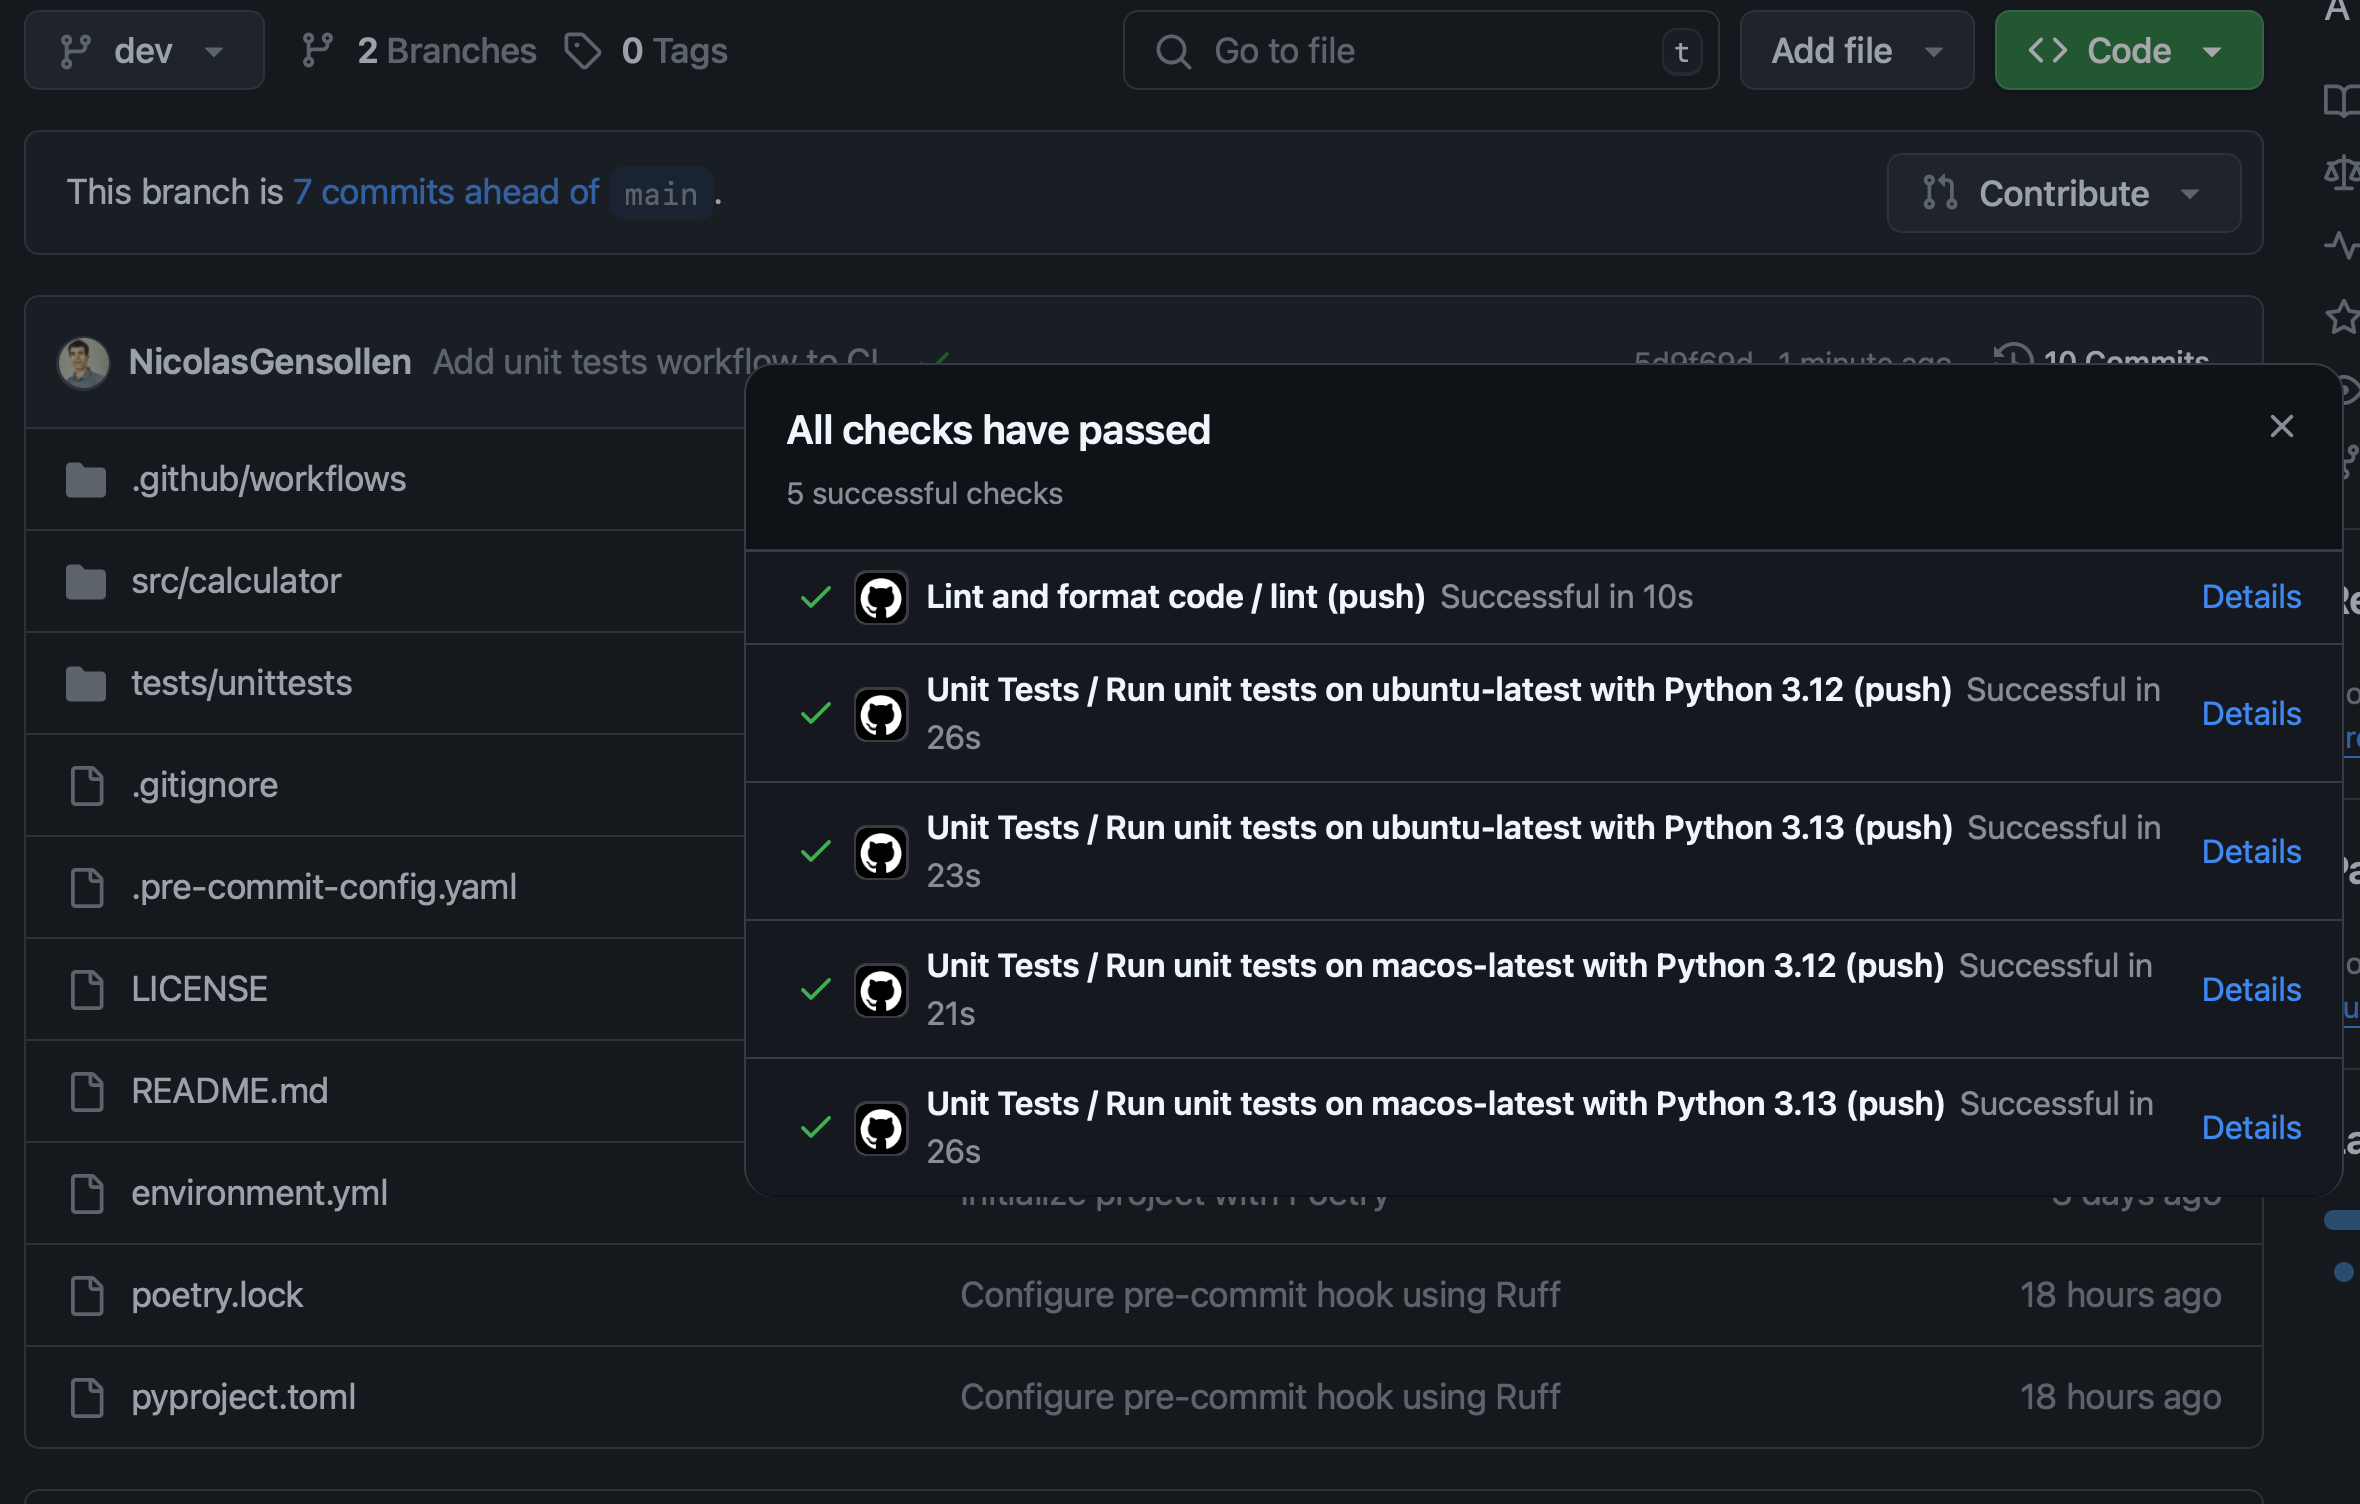

In [7]:
Image(filename="../images/github_action_unit_tests.png")

With this setup, we will be able by a very quick look to see whether a code proposal is both well formatted and not breaking any tests.

If it does, then we can move one to look at the code diff and focus on more important things.